In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import re
from keras.datasets import mnist

from IPython import display

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
SAVE_FOLDER = ''

In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_dcgan_generator(img_shape, z_dim, ker=3, useRelu=False):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=ker, strides=1, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=ker, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [0]:
def build_dcgan_discriminator(img_shape, ker=3):
    model = Sequential()

    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=ker, strides=2, padding='same',input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
def build_dcgan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [0]:
# random_z_for_generator = np.random.normal(0, 1, (4 * 4, 100))
# np.save('random_z_for_generator', random_z_for_generator)
# shutil.copy2('./random_z_for_generator.npy', SAVE_FOLDER)

shutil.copy2(SAVE_FOLDER + '/random_z_for_generator.npy', '/content/')
random_z_for_generator = np.load('./random_z_for_generator.npy')

In [0]:
def sample_images(folder, generator, z, ep, image_grid_rows=4, image_grid_columns=4):
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    if not os.path.exists(folder):
        os.mkdir(folder)

    img_name = 'image_at_epoch_{}.png'.format(ep+1)
    plt.savefig(img_name)
    shutil.move(img_name, os.path.join(os.getcwd(), folder))
    plt.show()

In [0]:
def train_dcgan(model_name, generator, discriminator, interations, batch_size, sample_interval):
    random_z_for_generator = np.random.normal(0, 1, (batch_size, 100))
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    dcgan = build_dcgan(generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = dcgan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            display.clear_output(wait=True)
            sample_images(model_name, generator, random_z_for_generator,iteration)
      
    shutil.make_archive('./' + model_name, 'zip', os.path.join(os.getcwd(), model_name))
    shutil.copy2('./' + model_name + '.zip', SAVE_FOLDER)

In [0]:
z_dim, img_shape = 100, (28,28,1)
iterations = 50000
batch_size = 128
sample_interval = 500

In [0]:
generator = build_dcgan_generator(img_shape, z_dim)

discriminator = build_dcgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
discriminator.trainable = False

W0707 02:09:49.584693 140405382805376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 02:09:49.604944 140405382805376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 02:09:49.607425 140405382805376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 02:09:49.668534 140405382805376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 02:09:49.670385 1404053828

#### NORMAL

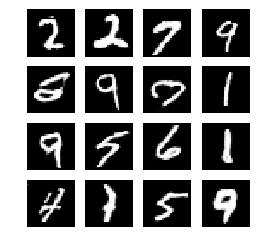

In [0]:
train_dcgan('1_normal', generator, discriminator, iterations, batch_size, sample_interval)

#### Use Adam(lr=0.0002, beta_1=0.5, beta_2=0.9)

In [0]:
del generator
del discriminator

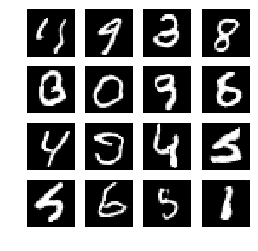

In [0]:
generator = build_dcgan_generator(img_shape, z_dim)

discriminator = build_dcgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

train_dcgan('2_use_adam', generator, discriminator, iterations, batch_size, sample_interval)
                      

#### Kernel = 5, Use ReLU

In [0]:
del generator
del discriminator

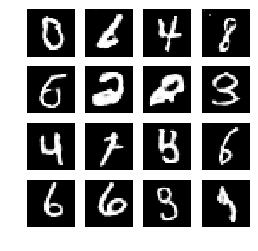

In [0]:
generator=build_dcgan_generator(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

train_dcgan('3_use_relu', generator, discriminator, iterations, batch_size, sample_interval)

#### Use NormalInitialize for layer
model = Sequential()
init = RandomNormal(mean=0.0, stddev=0.02)
model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=(64,64,3)))


In [0]:
del generator
del discriminator

In [0]:
from keras.initializers import RandomNormal
def build_dcgan_generator_with_init(img_shape, z_dim, ker=3, useRelu=False):
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=ker, strides=2, kernel_initializer=init, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
     # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=ker, strides=1, kernel_initializer=init, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=ker, strides=2, kernel_initializer=init, padding='same'))
    model.add(Activation('tanh'))

    return model

def build_dcgan_discriminator_with_init(img_shape, ker=3):
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential()
    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=ker, strides=2, kernel_initializer=init, padding='same',input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=ker, strides=2, kernel_initializer=init, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=ker, strides=2, kernel_initializer=init, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

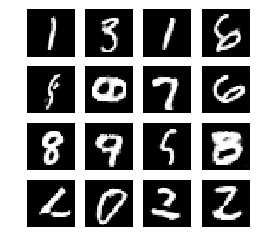

In [0]:
generator = build_dcgan_generator_with_init(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator_with_init(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

train_dcgan('4_d_g_random_init', generator, discriminator, iterations, batch_size, sample_interval)

#### Smooth labels


In [0]:
del generator
del discriminator

In [0]:
def smooth_fake_labels(y):
  y = y + np.random.random(y.shape) * 0.3
  return y

def smooth_real_labels(y):
  y = y - 0.3 + np.random.random(y.shape) * 0.3
  return y

In [0]:
def train_dcgan_smooth_label(model_name, generator, discriminator, interations, batch_size, sample_interval):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)

    dcgan = build_dcgan(generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        real = np.ones((batch_size, 1))
        real = smooth_real_labels(real)
        fake = np.zeros((batch_size, 1))
        fake = smooth_fake_labels(fake)

        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = dcgan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            display.clear_output(wait=True)
            sample_images(model_name, generator, random_z_for_generator,iteration)
      
    shutil.make_archive('./' + model_name, 'zip', os.path.join(os.getcwd(), model_name))
    shutil.copy2('./' + model_name + '.zip', SAVE_FOLDER)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.464954, acc.: 0.00%] [G loss: 0.860567]


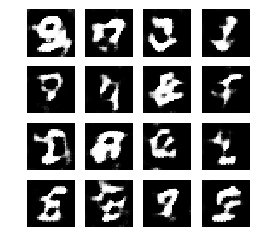

1000 [D loss: 0.486362, acc.: 0.00%] [G loss: 1.853580]


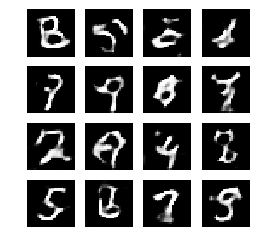

1500 [D loss: 0.620935, acc.: 0.00%] [G loss: 1.573991]


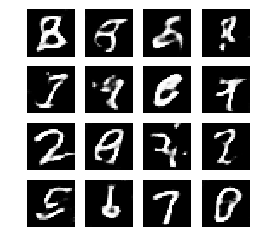

2000 [D loss: 0.508821, acc.: 0.00%] [G loss: 1.113642]


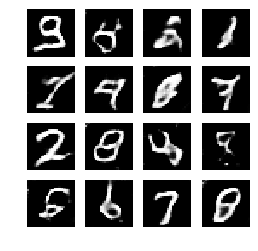

2500 [D loss: 0.432524, acc.: 0.00%] [G loss: 1.405939]


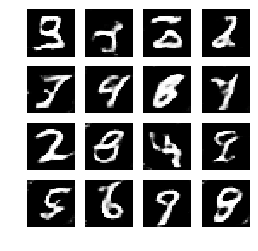

3000 [D loss: 0.429705, acc.: 0.00%] [G loss: 1.813097]


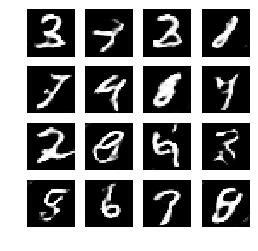

3500 [D loss: 0.612416, acc.: 0.00%] [G loss: 1.113893]


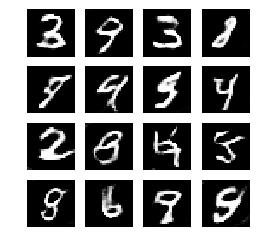

4000 [D loss: 0.471282, acc.: 0.00%] [G loss: 1.396866]


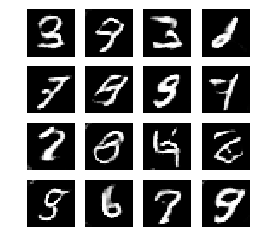

4500 [D loss: 0.516676, acc.: 0.00%] [G loss: 1.093200]


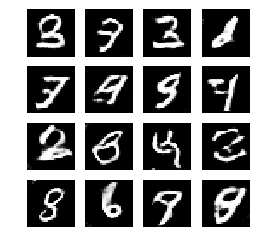

5000 [D loss: 0.534546, acc.: 0.00%] [G loss: 1.816284]


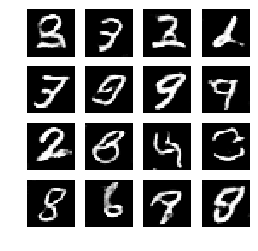

5500 [D loss: 0.463019, acc.: 0.00%] [G loss: 1.259667]


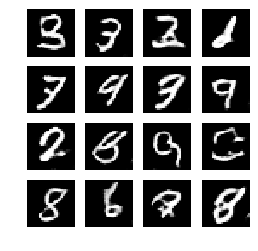

6000 [D loss: 0.461282, acc.: 0.00%] [G loss: 2.056227]


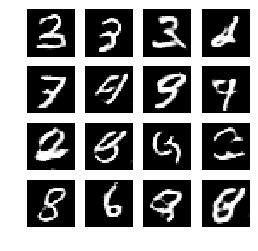

6500 [D loss: 0.460141, acc.: 0.00%] [G loss: 2.062411]


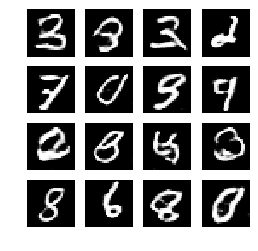

7000 [D loss: 0.446347, acc.: 0.00%] [G loss: 1.592528]


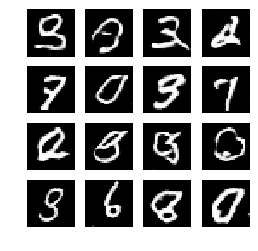

7500 [D loss: 0.479866, acc.: 0.00%] [G loss: 1.390080]


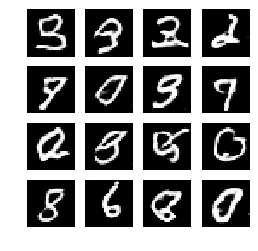

8000 [D loss: 0.459660, acc.: 0.00%] [G loss: 1.860456]


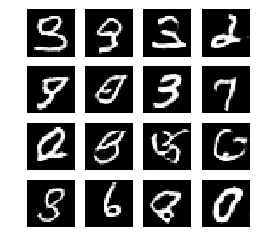

8500 [D loss: 0.456437, acc.: 0.00%] [G loss: 2.122348]


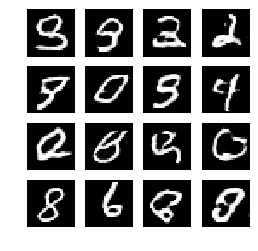

9000 [D loss: 0.521932, acc.: 0.00%] [G loss: 1.335013]


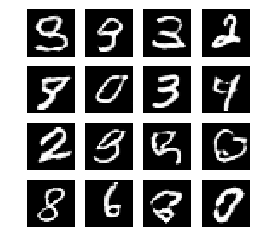

9500 [D loss: 0.435298, acc.: 0.00%] [G loss: 2.036658]


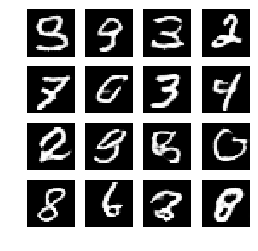

10000 [D loss: 0.454241, acc.: 0.00%] [G loss: 1.703993]


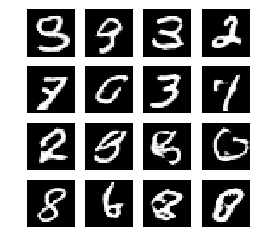

10500 [D loss: 0.485198, acc.: 0.00%] [G loss: 1.525742]


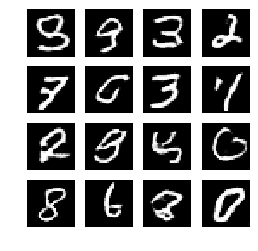

11000 [D loss: 0.466594, acc.: 0.00%] [G loss: 2.325047]


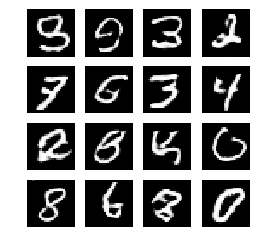

11500 [D loss: 0.420848, acc.: 0.00%] [G loss: 1.540226]


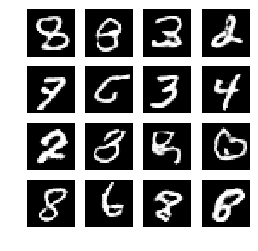

12000 [D loss: 0.433395, acc.: 0.00%] [G loss: 2.062002]


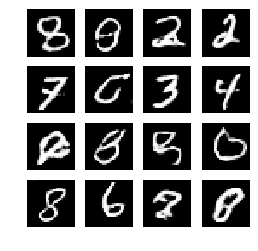

12500 [D loss: 0.432821, acc.: 0.00%] [G loss: 1.837669]


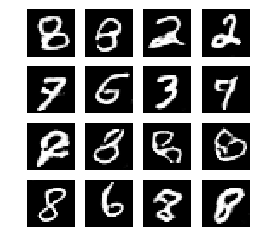

13000 [D loss: 0.446812, acc.: 0.00%] [G loss: 2.250690]


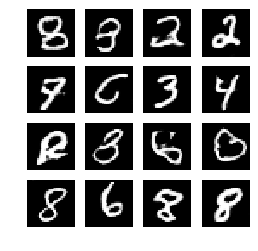

13500 [D loss: 0.437059, acc.: 0.00%] [G loss: 1.532009]


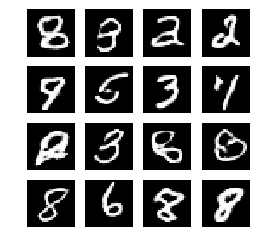

14000 [D loss: 0.430985, acc.: 0.00%] [G loss: 1.688026]


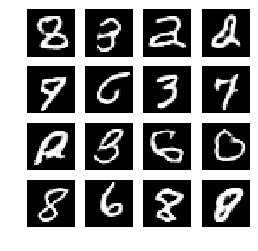

14500 [D loss: 0.424292, acc.: 0.00%] [G loss: 1.654788]


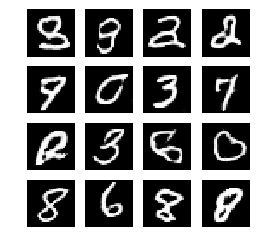

15000 [D loss: 0.462336, acc.: 0.00%] [G loss: 1.626405]


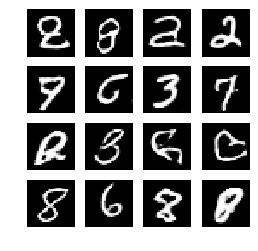

15500 [D loss: 0.457855, acc.: 0.00%] [G loss: 1.521131]


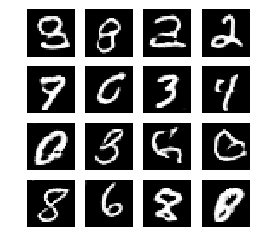

16000 [D loss: 0.454956, acc.: 0.00%] [G loss: 1.520682]


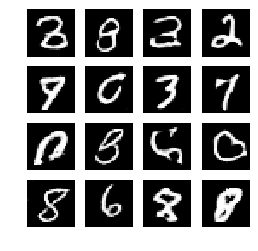

16500 [D loss: 0.535256, acc.: 0.00%] [G loss: 1.725611]


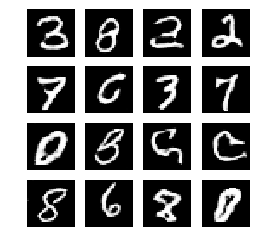

17000 [D loss: 0.470893, acc.: 0.00%] [G loss: 1.967723]


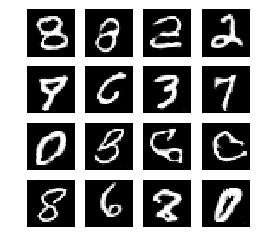

17500 [D loss: 0.478960, acc.: 0.00%] [G loss: 1.179088]


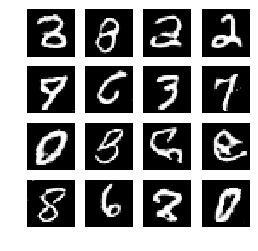

18000 [D loss: 0.464375, acc.: 0.00%] [G loss: 1.711907]


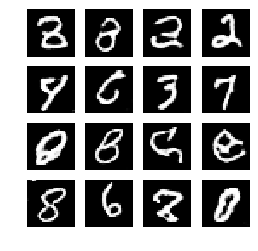

18500 [D loss: 0.421492, acc.: 0.00%] [G loss: 1.590457]


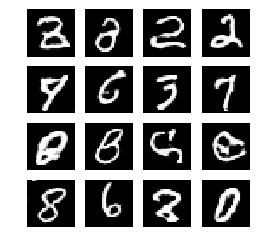

19000 [D loss: 0.445234, acc.: 0.00%] [G loss: 1.324807]


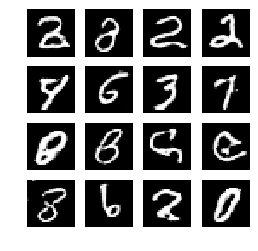

19500 [D loss: 0.438862, acc.: 0.00%] [G loss: 1.486734]


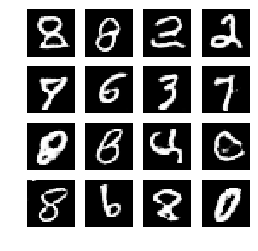

20000 [D loss: 0.460466, acc.: 0.00%] [G loss: 1.559309]


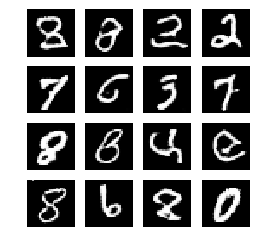

20500 [D loss: 0.466438, acc.: 0.00%] [G loss: 1.302862]


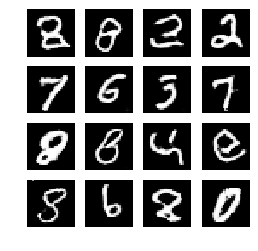

21000 [D loss: 0.482293, acc.: 0.00%] [G loss: 1.164209]


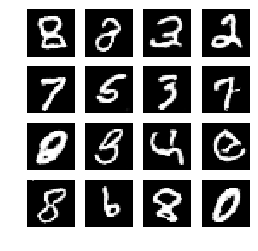

21500 [D loss: 0.437020, acc.: 0.00%] [G loss: 1.810511]


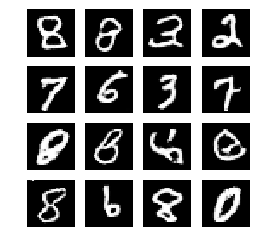

22000 [D loss: 0.444865, acc.: 0.00%] [G loss: 1.739663]


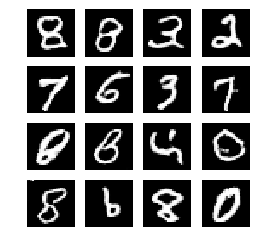

22500 [D loss: 0.434537, acc.: 0.00%] [G loss: 1.869073]


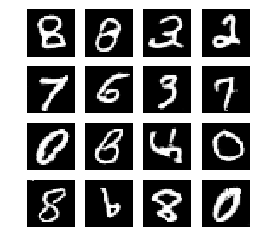

23000 [D loss: 0.440572, acc.: 0.00%] [G loss: 1.754899]


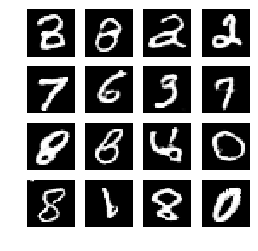

23500 [D loss: 0.470967, acc.: 0.00%] [G loss: 1.421331]


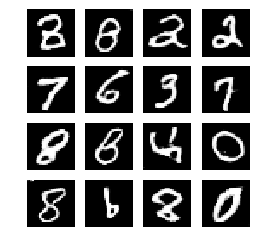

24000 [D loss: 0.453240, acc.: 0.00%] [G loss: 1.337685]


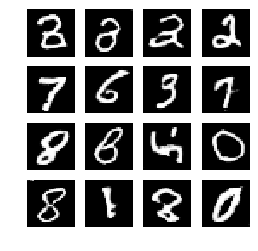

24500 [D loss: 0.497943, acc.: 0.00%] [G loss: 1.934911]


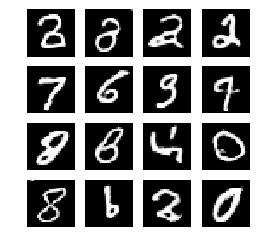

25000 [D loss: 0.445921, acc.: 0.00%] [G loss: 1.980502]


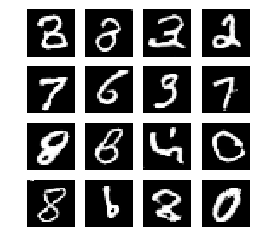

25500 [D loss: 0.538947, acc.: 0.00%] [G loss: 1.663713]


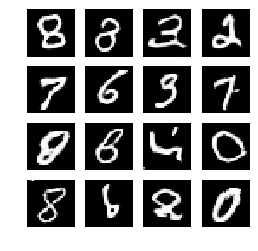

26000 [D loss: 0.443992, acc.: 0.00%] [G loss: 1.593647]


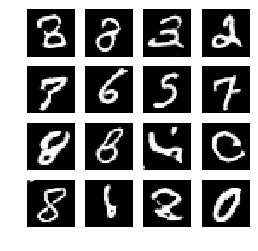

26500 [D loss: 0.454191, acc.: 0.00%] [G loss: 2.106103]


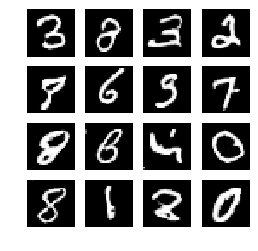

27000 [D loss: 0.460177, acc.: 0.00%] [G loss: 2.252423]


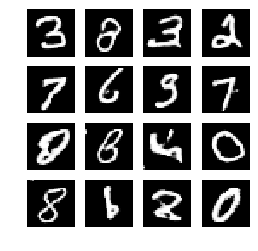

27500 [D loss: 0.430324, acc.: 0.00%] [G loss: 1.757762]


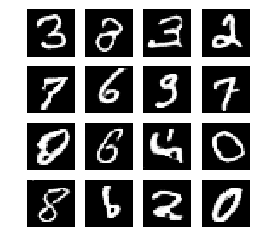

28000 [D loss: 0.497287, acc.: 0.00%] [G loss: 1.565254]


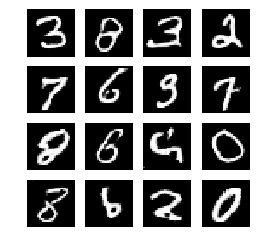

28500 [D loss: 0.453784, acc.: 0.00%] [G loss: 1.534666]


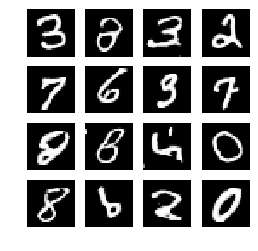

29000 [D loss: 0.432099, acc.: 0.00%] [G loss: 1.636531]


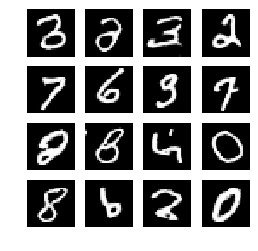

29500 [D loss: 0.459746, acc.: 0.00%] [G loss: 1.966029]


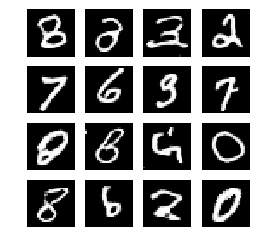

30000 [D loss: 0.445961, acc.: 0.00%] [G loss: 0.909768]


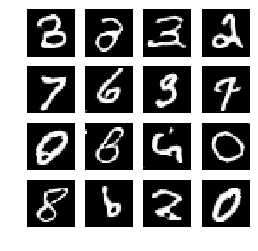

30500 [D loss: 0.443866, acc.: 0.00%] [G loss: 2.182592]


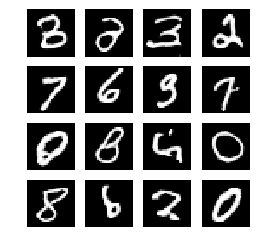

31000 [D loss: 0.464922, acc.: 0.00%] [G loss: 2.372631]


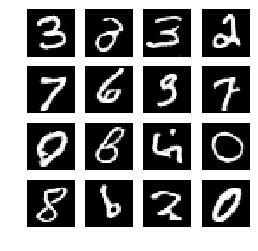

31500 [D loss: 0.441211, acc.: 0.00%] [G loss: 2.441284]


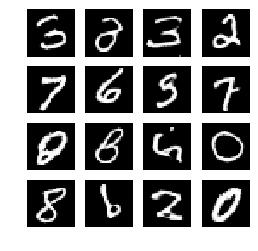

32000 [D loss: 0.482967, acc.: 0.00%] [G loss: 1.224842]


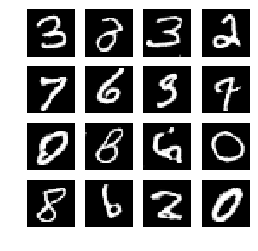

32500 [D loss: 0.435382, acc.: 0.00%] [G loss: 2.017583]


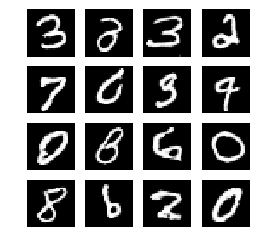

33000 [D loss: 0.439938, acc.: 0.00%] [G loss: 1.578628]


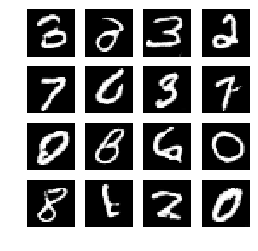

33500 [D loss: 0.439840, acc.: 0.00%] [G loss: 1.989691]


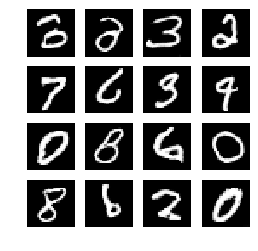

34000 [D loss: 0.448524, acc.: 0.00%] [G loss: 1.500761]


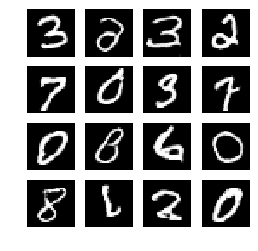

34500 [D loss: 0.476807, acc.: 0.00%] [G loss: 1.106269]


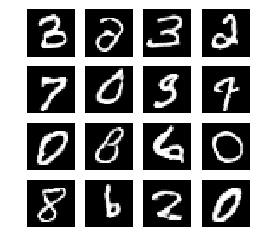

35000 [D loss: 0.431925, acc.: 0.00%] [G loss: 1.925557]


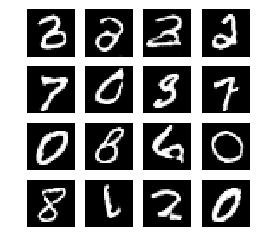

35500 [D loss: 0.454282, acc.: 0.00%] [G loss: 1.428583]


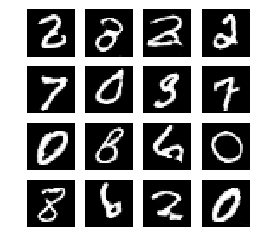

36000 [D loss: 0.430878, acc.: 0.00%] [G loss: 1.521827]


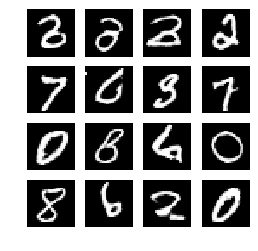

36500 [D loss: 0.447985, acc.: 0.00%] [G loss: 1.882026]


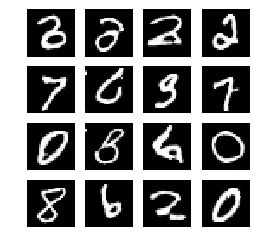

37000 [D loss: 0.470030, acc.: 0.00%] [G loss: 1.847063]


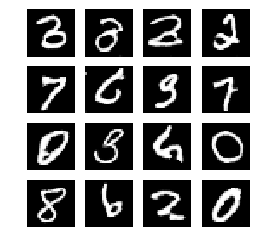

37500 [D loss: 0.620048, acc.: 0.00%] [G loss: 1.354416]


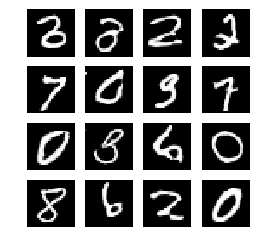

38000 [D loss: 0.452898, acc.: 0.00%] [G loss: 1.558377]


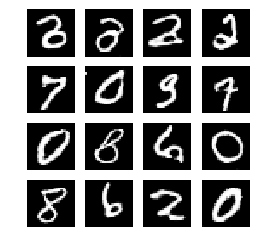

38500 [D loss: 0.440407, acc.: 0.00%] [G loss: 1.894671]


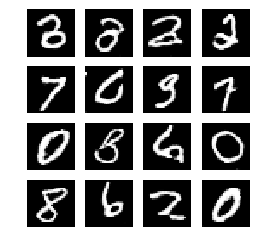

39000 [D loss: 0.471522, acc.: 0.00%] [G loss: 1.568012]


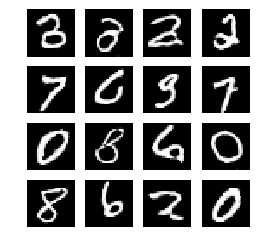

39500 [D loss: 0.464557, acc.: 0.00%] [G loss: 1.683353]


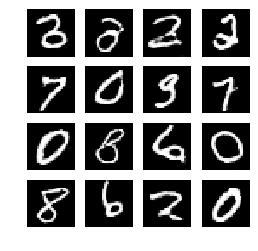

40000 [D loss: 0.474726, acc.: 0.00%] [G loss: 1.649406]


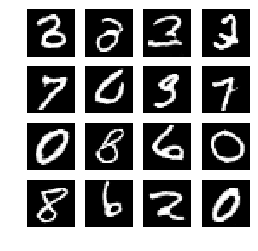

40500 [D loss: 0.430961, acc.: 0.00%] [G loss: 1.481928]


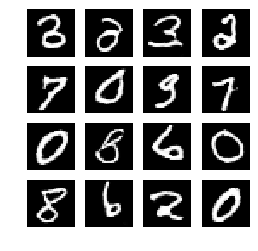

41000 [D loss: 0.436324, acc.: 0.00%] [G loss: 1.938380]


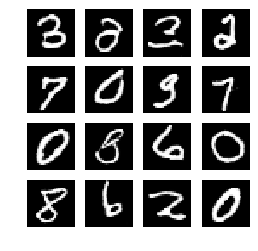

41500 [D loss: 0.453509, acc.: 0.00%] [G loss: 1.324716]


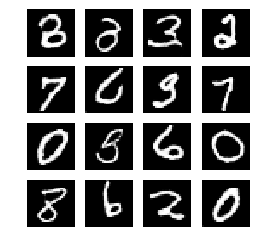

42000 [D loss: 0.453164, acc.: 0.00%] [G loss: 2.295272]


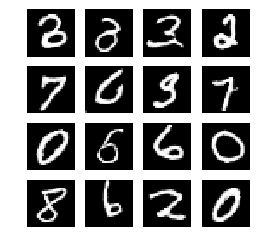

42500 [D loss: 0.431612, acc.: 0.00%] [G loss: 1.672754]


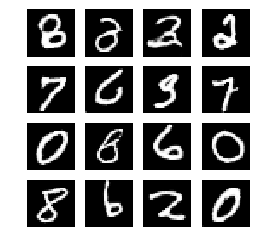

43000 [D loss: 0.444236, acc.: 0.00%] [G loss: 1.779595]


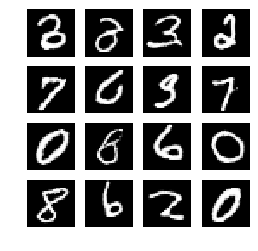

43500 [D loss: 0.443599, acc.: 0.00%] [G loss: 1.631971]


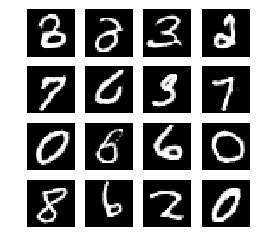

44000 [D loss: 0.450900, acc.: 0.00%] [G loss: 1.375835]


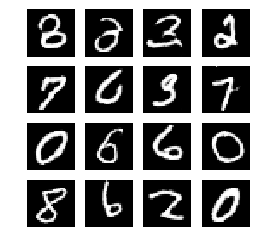

44500 [D loss: 0.449081, acc.: 0.00%] [G loss: 1.688645]


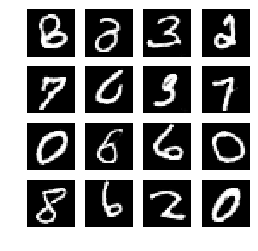

45000 [D loss: 0.462542, acc.: 0.00%] [G loss: 2.151892]


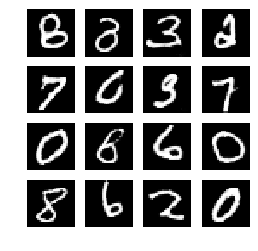

45500 [D loss: 0.443066, acc.: 0.00%] [G loss: 2.101645]


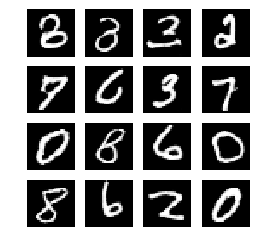

46000 [D loss: 0.426078, acc.: 0.00%] [G loss: 2.053788]


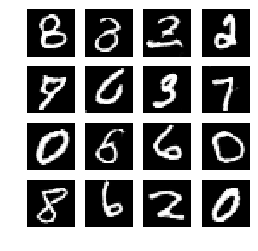

46500 [D loss: 0.428560, acc.: 0.00%] [G loss: 1.754845]


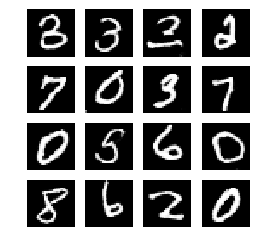

47000 [D loss: 0.456548, acc.: 0.00%] [G loss: 1.916461]


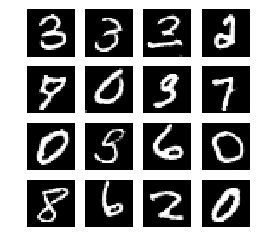

47500 [D loss: 0.441472, acc.: 0.00%] [G loss: 1.651804]


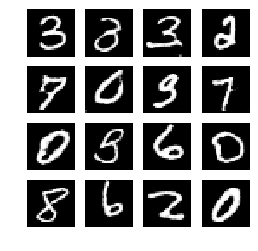

48000 [D loss: 0.479693, acc.: 0.00%] [G loss: 2.065746]


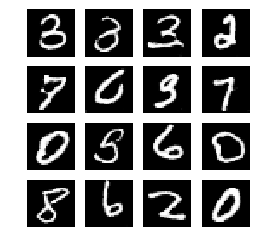

48500 [D loss: 0.426983, acc.: 0.00%] [G loss: 1.835297]


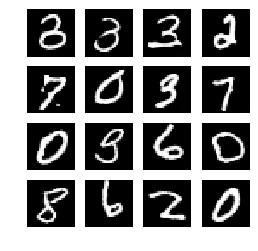

49000 [D loss: 0.477623, acc.: 0.00%] [G loss: 2.615745]


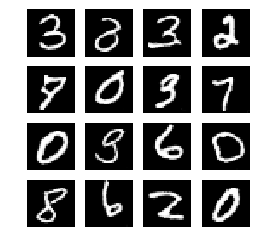

49500 [D loss: 0.465855, acc.: 0.00%] [G loss: 1.329994]


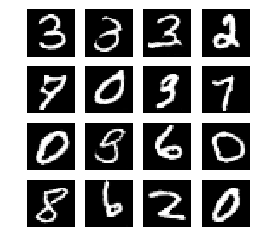

50000 [D loss: 0.453179, acc.: 0.00%] [G loss: 1.654659]


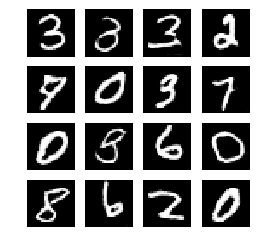

In [0]:
generator = build_dcgan_generator_with_init(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator_with_init(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

train_dcgan_smooth_label('5_smooth_label', generator, discriminator, iterations, batch_size, sample_interval)

#### Mix some miss-classified label

In [0]:
del generator
del discriminator

In [0]:
def noisy_labels(y, p_flip):
    n_select = int(y.shape[0] * p_flip)
    idx = np.random.choice([i for i in range(y.shape[0])], size = n_select)
    y[idx] = 1 - y[idx]
    return y

In [0]:
def train_dcgan_smooth_label_mix(model_name, generator, discriminator, interations, batch_size, sample_interval):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)

    dcgan = build_dcgan(generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        real = np.ones((batch_size, 1))
        real = smooth_real_labels(real)
        fake = np.zeros((batch_size, 1))
        fake = smooth_fake_labels(fake)

        real = noisy_labels(real, 0.03)
        fake = noisy_labels(fake, 0.03)

        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = dcgan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            display.clear_output(wait=True)
            sample_images(model_name, generator, random_z_for_generator,iteration)
      
    shutil.make_archive('./' + model_name, 'zip', os.path.join(os.getcwd(), model_name))
    shutil.copy2('./' + model_name + '.zip', SAVE_FOLDER)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.523333, acc.: 0.00%] [G loss: 1.999027]


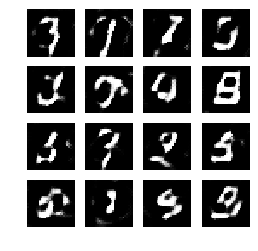

1000 [D loss: 0.567501, acc.: 0.00%] [G loss: 1.518846]


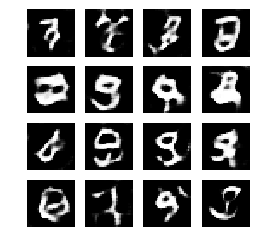

1500 [D loss: 0.539727, acc.: 0.00%] [G loss: 1.451136]


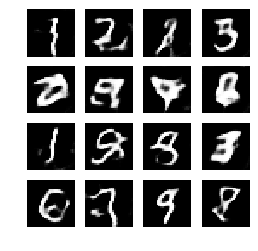

2000 [D loss: 0.564495, acc.: 0.00%] [G loss: 1.491673]


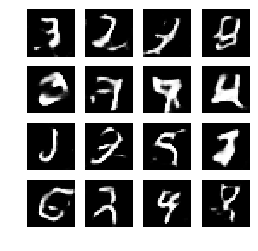

2500 [D loss: 0.458996, acc.: 0.00%] [G loss: 1.504792]


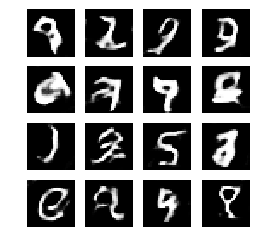

3000 [D loss: 0.539432, acc.: 0.00%] [G loss: 1.256487]


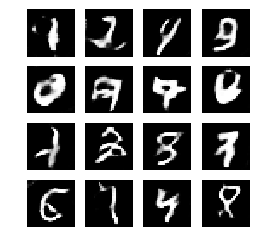

3500 [D loss: 0.514744, acc.: 0.00%] [G loss: 1.323633]


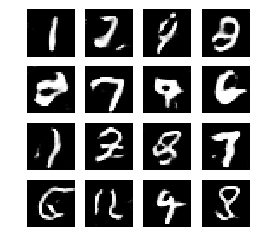

4000 [D loss: 0.603732, acc.: 0.00%] [G loss: 1.853449]


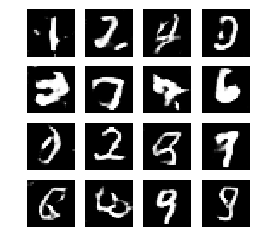

4500 [D loss: 0.487608, acc.: 0.00%] [G loss: 1.663594]


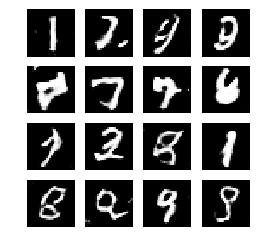

5000 [D loss: 0.526116, acc.: 0.00%] [G loss: 1.396648]


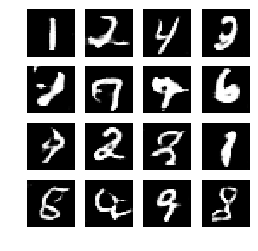

5500 [D loss: 0.470390, acc.: 0.00%] [G loss: 1.393238]


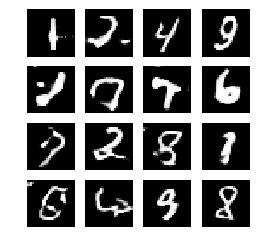

6000 [D loss: 0.477318, acc.: 0.00%] [G loss: 1.298059]


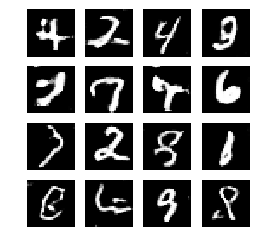

6500 [D loss: 0.484679, acc.: 0.00%] [G loss: 1.422654]


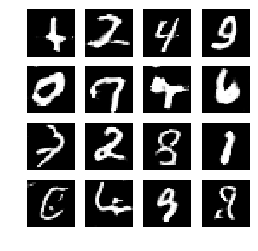

7000 [D loss: 0.487330, acc.: 0.00%] [G loss: 1.745210]


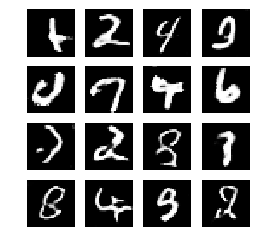

7500 [D loss: 0.479223, acc.: 0.00%] [G loss: 2.377072]


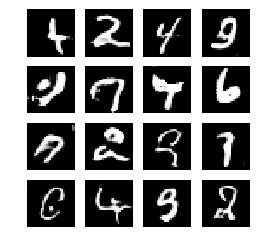

8000 [D loss: 0.483404, acc.: 0.00%] [G loss: 1.719414]


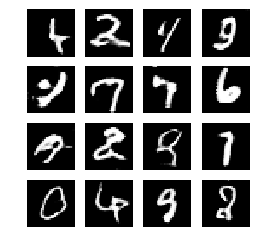

8500 [D loss: 0.458477, acc.: 0.00%] [G loss: 1.433789]


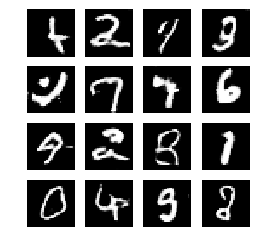

9000 [D loss: 0.468475, acc.: 0.00%] [G loss: 1.729761]


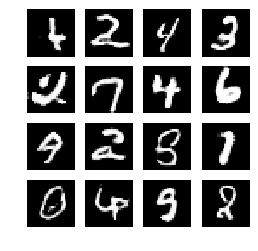

9500 [D loss: 0.527055, acc.: 0.00%] [G loss: 1.568510]


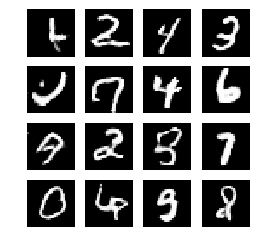

10000 [D loss: 0.493836, acc.: 0.00%] [G loss: 1.789800]


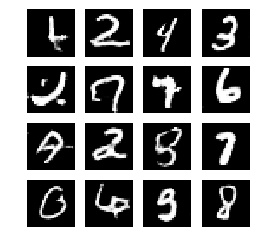

10500 [D loss: 0.583312, acc.: 0.00%] [G loss: 1.360818]


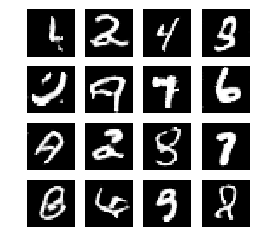

11000 [D loss: 0.461289, acc.: 0.00%] [G loss: 1.694435]


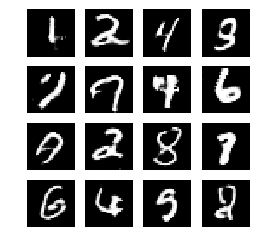

11500 [D loss: 0.501100, acc.: 0.00%] [G loss: 1.817613]


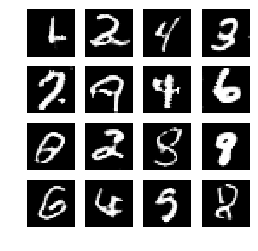

12000 [D loss: 0.483413, acc.: 0.00%] [G loss: 1.796689]


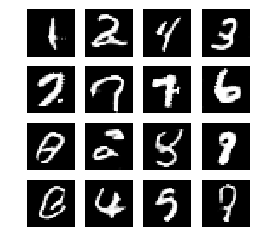

12500 [D loss: 0.462404, acc.: 0.00%] [G loss: 1.399241]


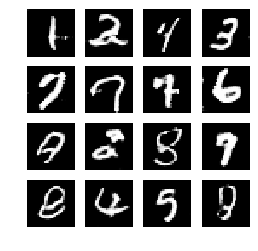

13000 [D loss: 0.502509, acc.: 0.00%] [G loss: 1.670028]


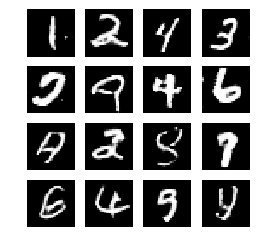

13500 [D loss: 0.471858, acc.: 0.00%] [G loss: 1.422810]


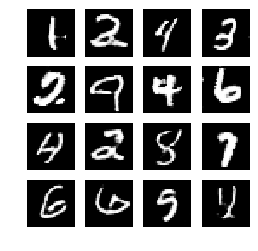

14000 [D loss: 0.598094, acc.: 0.00%] [G loss: 1.209851]


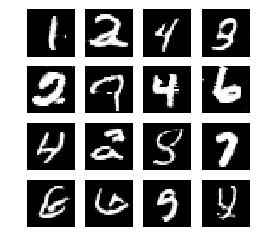

14500 [D loss: 0.486246, acc.: 0.00%] [G loss: 1.722234]


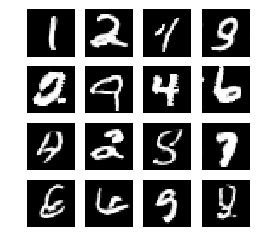

15000 [D loss: 0.542502, acc.: 0.00%] [G loss: 1.482106]


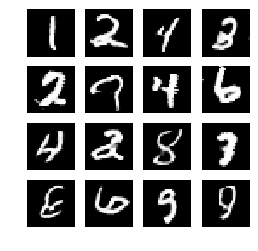

15500 [D loss: 0.473210, acc.: 0.00%] [G loss: 1.077030]


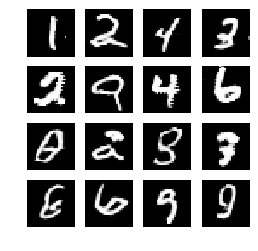

16000 [D loss: 0.479412, acc.: 0.00%] [G loss: 1.822533]


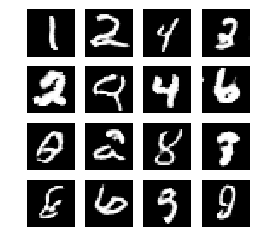

16500 [D loss: 0.462791, acc.: 0.00%] [G loss: 1.252856]


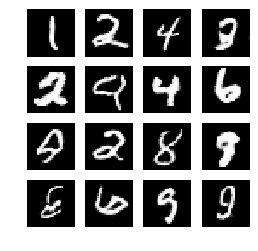

17000 [D loss: 0.472705, acc.: 0.00%] [G loss: 1.083658]


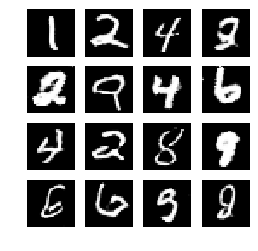

17500 [D loss: 0.514326, acc.: 0.00%] [G loss: 1.513495]


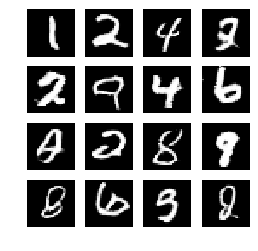

18000 [D loss: 0.464230, acc.: 0.00%] [G loss: 1.395133]


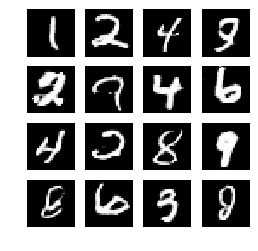

18500 [D loss: 0.458202, acc.: 0.00%] [G loss: 1.612279]


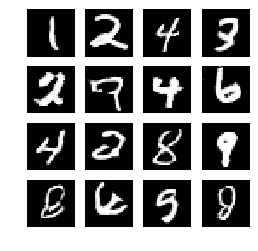

19000 [D loss: 0.579962, acc.: 0.00%] [G loss: 1.487520]


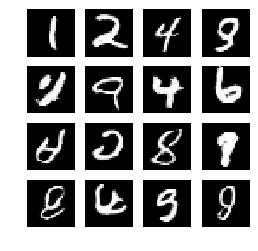

19500 [D loss: 0.495286, acc.: 0.00%] [G loss: 1.409195]


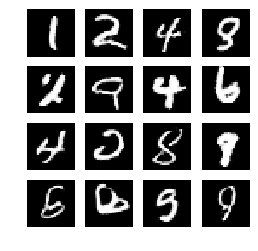

20000 [D loss: 0.527874, acc.: 0.00%] [G loss: 1.854427]


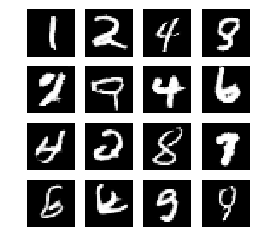

20500 [D loss: 0.478477, acc.: 0.00%] [G loss: 1.329243]


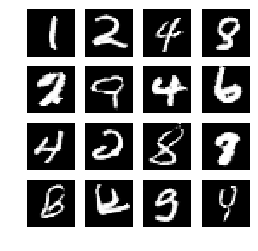

21000 [D loss: 0.475864, acc.: 0.00%] [G loss: 1.752585]


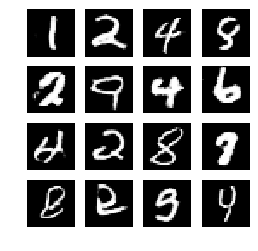

21500 [D loss: 0.480372, acc.: 0.00%] [G loss: 1.865623]


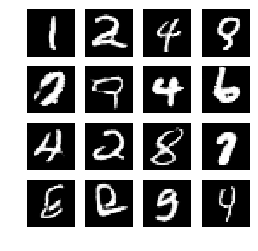

22000 [D loss: 0.481453, acc.: 0.00%] [G loss: 1.292679]


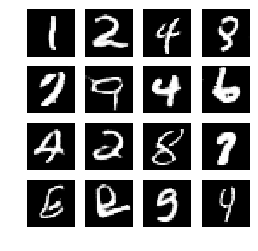

22500 [D loss: 0.472446, acc.: 0.00%] [G loss: 1.988110]


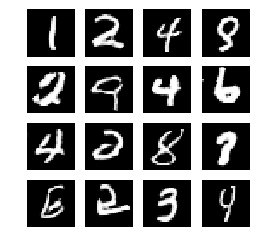

23000 [D loss: 0.466254, acc.: 0.00%] [G loss: 1.621109]


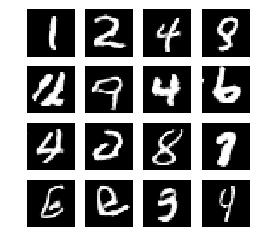

23500 [D loss: 0.481843, acc.: 0.00%] [G loss: 1.494889]


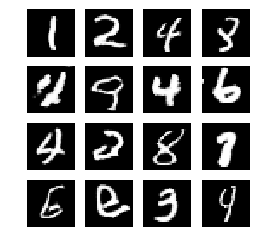

24000 [D loss: 0.523584, acc.: 0.00%] [G loss: 2.048434]


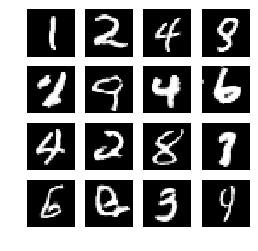

24500 [D loss: 0.471918, acc.: 0.00%] [G loss: 1.536483]


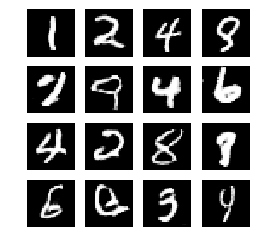

25000 [D loss: 0.483808, acc.: 0.00%] [G loss: 1.828091]


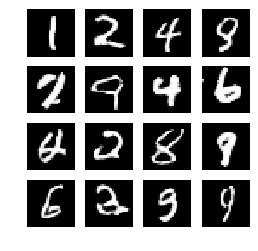

25500 [D loss: 0.489156, acc.: 0.00%] [G loss: 1.488770]


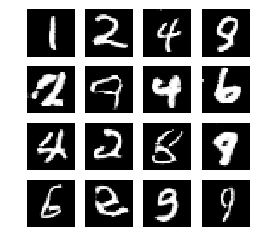

26000 [D loss: 0.451777, acc.: 0.00%] [G loss: 1.849585]


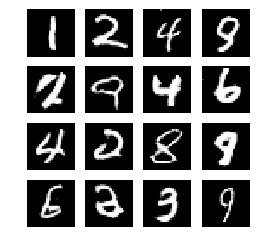

26500 [D loss: 0.451266, acc.: 0.00%] [G loss: 1.720471]


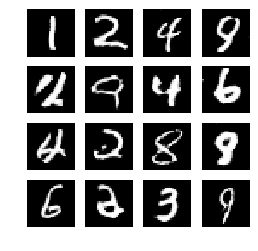

27000 [D loss: 0.541625, acc.: 0.00%] [G loss: 1.201098]


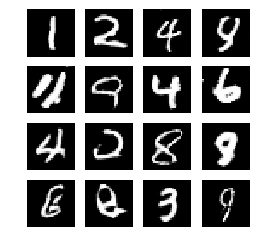

27500 [D loss: 0.479830, acc.: 0.00%] [G loss: 1.310373]


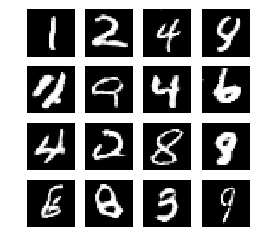

28000 [D loss: 0.504464, acc.: 0.00%] [G loss: 1.693443]


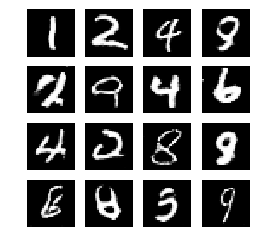

28500 [D loss: 0.485113, acc.: 0.00%] [G loss: 2.037907]


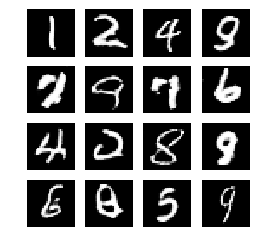

29000 [D loss: 0.478963, acc.: 0.00%] [G loss: 1.387777]


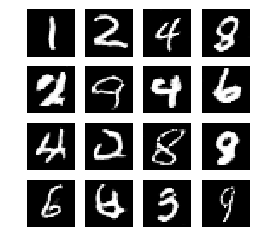

29500 [D loss: 0.462916, acc.: 0.00%] [G loss: 1.694456]


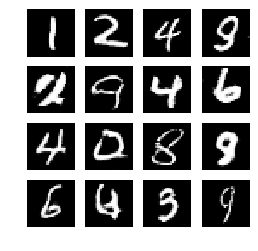

30000 [D loss: 0.455256, acc.: 0.00%] [G loss: 1.655638]


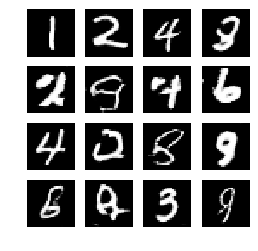

30500 [D loss: 0.476405, acc.: 0.00%] [G loss: 2.088004]


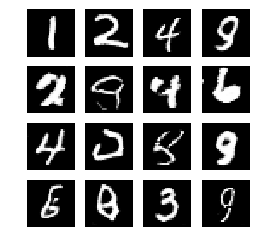

31000 [D loss: 0.450523, acc.: 0.00%] [G loss: 1.932860]


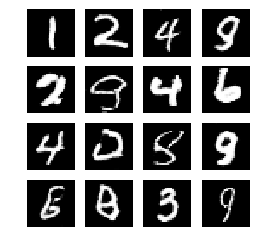

31500 [D loss: 0.492877, acc.: 0.00%] [G loss: 1.587497]


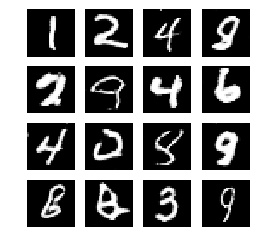

32000 [D loss: 0.468310, acc.: 0.00%] [G loss: 1.663908]


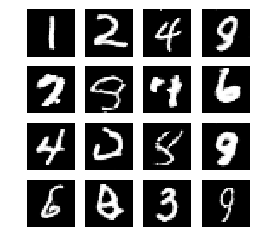

32500 [D loss: 0.465217, acc.: 0.00%] [G loss: 2.005059]


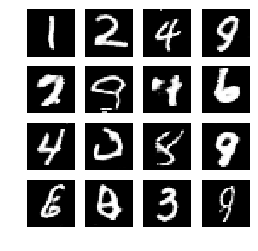

33000 [D loss: 0.468356, acc.: 0.00%] [G loss: 1.538706]


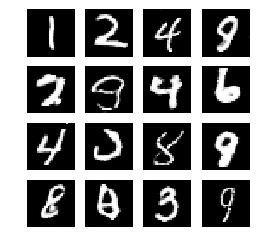

33500 [D loss: 0.476688, acc.: 0.00%] [G loss: 1.289816]


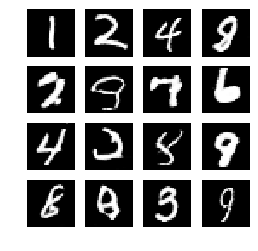

34000 [D loss: 0.469784, acc.: 0.00%] [G loss: 1.738746]


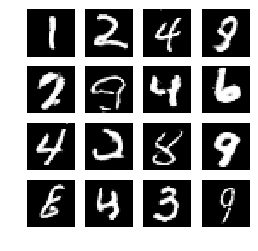

34500 [D loss: 0.491067, acc.: 0.00%] [G loss: 1.258744]


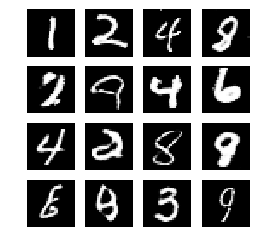

35000 [D loss: 0.467198, acc.: 0.00%] [G loss: 1.649895]


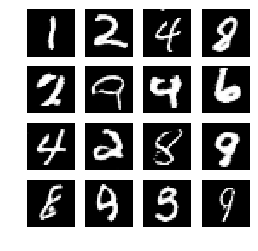

35500 [D loss: 0.461668, acc.: 0.00%] [G loss: 1.677310]


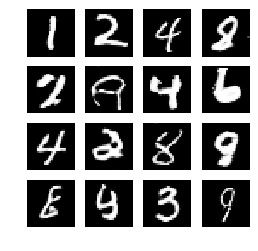

36000 [D loss: 0.489696, acc.: 0.00%] [G loss: 1.657276]


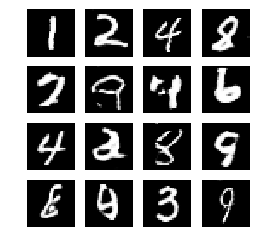

36500 [D loss: 0.454891, acc.: 0.00%] [G loss: 1.479967]


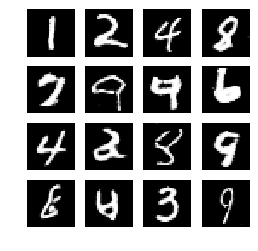

37000 [D loss: 0.455803, acc.: 0.00%] [G loss: 2.024786]


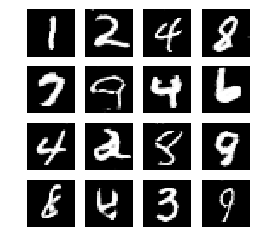

37500 [D loss: 0.478003, acc.: 0.00%] [G loss: 1.444020]


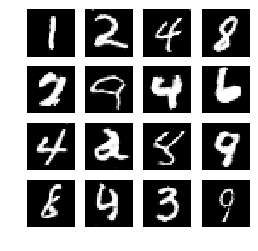

38000 [D loss: 0.475356, acc.: 0.00%] [G loss: 1.498343]


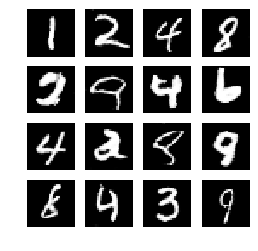

38500 [D loss: 0.475245, acc.: 0.00%] [G loss: 1.741628]


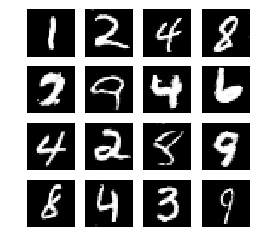

39000 [D loss: 0.560360, acc.: 0.00%] [G loss: 2.908072]


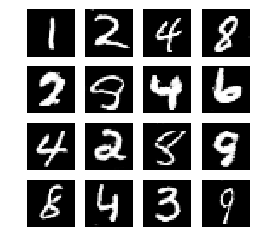

39500 [D loss: 0.468580, acc.: 0.00%] [G loss: 1.863491]


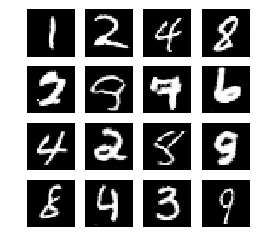

40000 [D loss: 0.477446, acc.: 0.00%] [G loss: 1.420810]


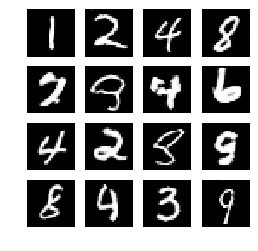

40500 [D loss: 0.491710, acc.: 0.00%] [G loss: 1.504933]


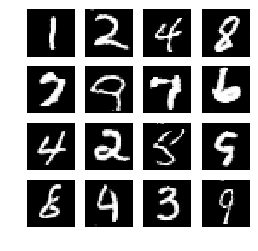

41000 [D loss: 0.495875, acc.: 0.00%] [G loss: 1.222261]


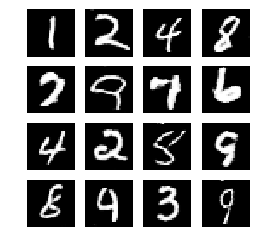

41500 [D loss: 0.453226, acc.: 0.00%] [G loss: 1.548337]


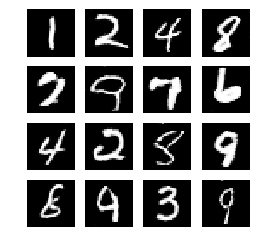

42000 [D loss: 0.466229, acc.: 0.00%] [G loss: 1.401909]


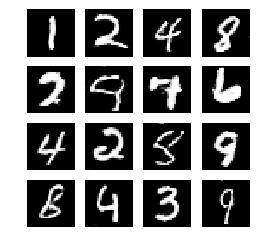

42500 [D loss: 0.501603, acc.: 0.00%] [G loss: 1.604420]


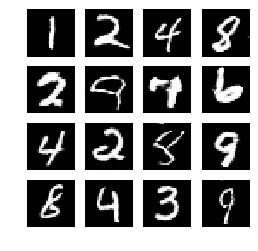

43000 [D loss: 0.516089, acc.: 0.00%] [G loss: 1.299077]


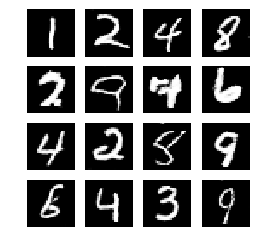

43500 [D loss: 0.451729, acc.: 0.00%] [G loss: 1.229103]


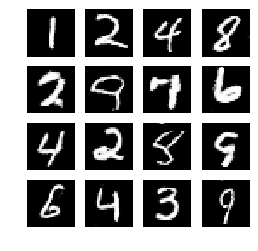

44000 [D loss: 0.474410, acc.: 0.00%] [G loss: 1.567022]


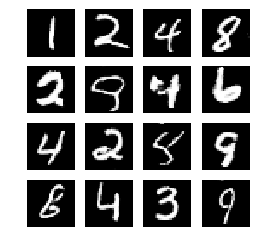

44500 [D loss: 0.499957, acc.: 0.00%] [G loss: 1.492984]


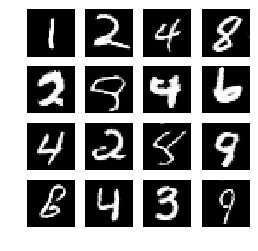

45000 [D loss: 0.455208, acc.: 0.00%] [G loss: 1.903087]


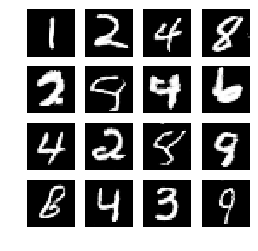

45500 [D loss: 0.489336, acc.: 0.00%] [G loss: 1.203280]


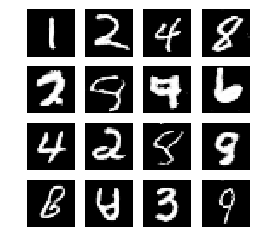

46000 [D loss: 0.498172, acc.: 0.00%] [G loss: 1.464808]


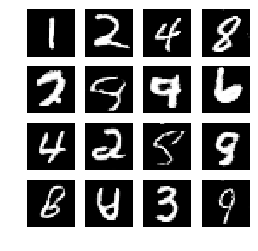

46500 [D loss: 0.465092, acc.: 0.00%] [G loss: 1.458787]


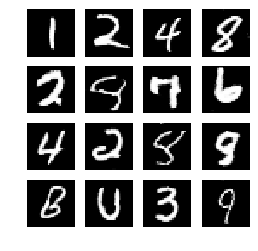

47000 [D loss: 0.456372, acc.: 0.00%] [G loss: 2.026789]


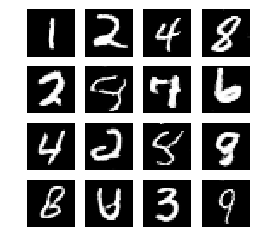

47500 [D loss: 0.482621, acc.: 0.00%] [G loss: 1.629546]


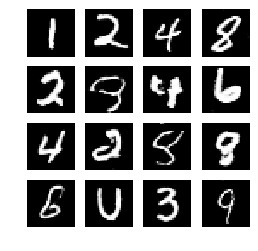

48000 [D loss: 0.458655, acc.: 0.00%] [G loss: 2.419189]


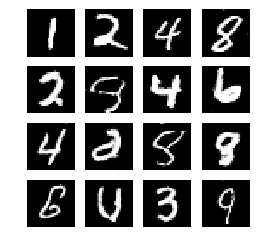

48500 [D loss: 0.453424, acc.: 0.00%] [G loss: 1.335350]


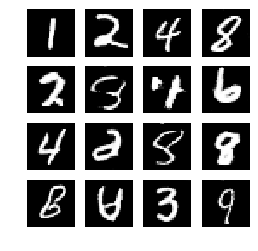

49000 [D loss: 0.480002, acc.: 0.00%] [G loss: 1.475574]


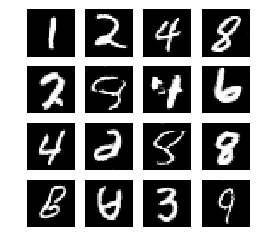

49500 [D loss: 0.569401, acc.: 0.00%] [G loss: 1.108759]


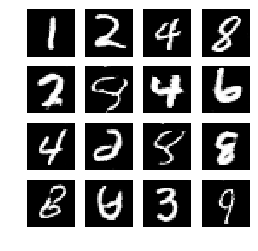

50000 [D loss: 0.478487, acc.: 0.00%] [G loss: 1.202962]


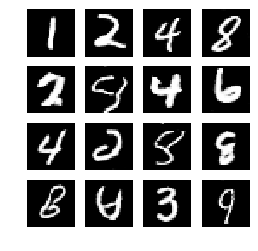

In [0]:
generator = build_dcgan_generator_with_init(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_dcgan_discriminator_with_init(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

train_dcgan_smooth_label_mix('6_smooth_label_mix', generator, discriminator, iterations, batch_size, sample_interval)